In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

burglary_pd = pd.read_csv("../data/burglary_cpts.csv")
burglary_pd

,p,key,burglary,earthquake,alarm,john,mary
0,0.950,alarm,1,1,0,0,0
1,0.940,alarm,1,-1,0,0,0
2,0.290,alarm,-1,1,0,0,0
3,0.001,alarm,-1,-1,0,0,0
4,0.900,john,0,0,1,0,0
5,0.050,john,0,0,-1,0,0
6,0.700,mary,0,0,1,0,0
7,0.010,mary,0,0,-1,0,0
8,0.001,burglary,0,0,0,0,0
9,0.002,earthquake,0,0,0,0,0


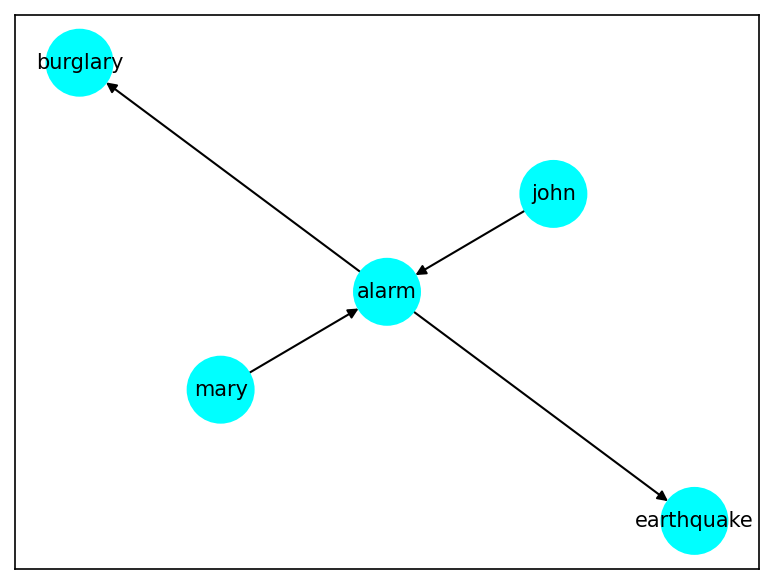

In [18]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

class Thing:
    def __init__(self, name=''):
        self.name = name
    def __repr__(self):
        return self.name

# 贝叶斯网络的节点结构是向上的
class Node(Thing):
    def __init__(self, name, parents=None, loc=None, state=-1):
        super().__init__(name)
        self.parents = parents if parents is not None else {}
        self.loc = loc
        self.state = state
    def add_parent(self, parent_name, parent_weight):
        self.parents[parent_name] = parent_weight

class Graph(Thing):
    def __init__(self, name):
        super().__init__(name)
        self.node_list = []
        self.node_map = {}
    def add_node(self, node):
        self.node_list.append(node)
        self.node_map[node.name] = node
    def draw(self, font_size=10, k_layout=1, node_size=1000, title=''):
        plt.rcdefaults()
        plt.rcParams['figure.dpi'] = 150
        g = nx.DiGraph()
        edges = []
        edges_map = {}
        for node in self.node_list:
            for key, val in node.parents.items():
                edges.append((node.name, key, 1 / val))
                edges_map[(node.name, key)] = val
        g.add_weighted_edges_from(edges)
        pos_map = {}
        nodes_label = {}
        for node in self.node_list:
            if node.loc is not None:
                pos_map[node.name] = node.loc
            nodes_label[node.name] = node.name
        rand_seed = random.randint(1, 1000)
        if len(pos_map) > 0:
            locs = nx.spring_layout(g, pos=pos_map,
                                    fixed=pos_map.keys(),
                                    seed=rand_seed,
                                    k=k_layout)
        else:
            locs = nx.spring_layout(g, seed=rand_seed,
                                    k=k_layout)
        color_arr = []
        for node in self.node_list:
            color_arr.append(node.state)
        nx.draw_networkx_nodes(g, pos=locs,
                               node_size=node_size,
                               node_color=color_arr,
                               cmap=plt.cm.cool)
        nx.draw_networkx_labels(g, pos=locs,
                                labels=nodes_label,
                                font_size=font_size,
                                font_color='black')
        nx.draw_networkx_edges(g, pos=locs,
                               node_size=node_size)
        plt.title(title)
        plt.show()

class BayesNode(Node):
    def __init__(self, name):
        super().__init__(name)
        self.cpt = {}
    def cpt_score(self, evidence):  # 只返回为1的概率
        # 我们假设，调用这个方法的时候，该节点的所有支撑变量都进了evidence（这需要推理过程确保）
        key_tuple = []
        for parent in self.parents:
            if parent in evidence:
                key_tuple.append(evidence[parent])
        key_tuple = tuple(key_tuple)
        # 对于先验概率，其tuple应该是一个空值，这样可以直接算出需要的p
        p = self.cpt[key_tuple]
        return p
    def __repr__(self):
        return "{}{}".format(self.name,
                             tuple(p for p in self.parents))

class BayesNet(Graph):
    def __init__(self, name='', cpt_pd="../data/burglary_cpts.csv"):
        super().__init__(name)
        self.cpt_pd = pd.read_csv(cpt_pd)
        self.parse_cpts(self.cpt_pd)
    def parse_cpts(self, data_pd):
        # 首先加载各个点
        # 注意这里必须严格确保源文件中列的顺序，因为检查的时候是从先验概率一层一层补充检查的
        for col in data_pd.columns[2:]:
            self.add_node(BayesNode(col))
        # 构造各个点内部关系
        for idx, row in data_pd.iterrows():
            p, key = row['p'], row['key']
            row['p'], row['key'] = 0, 0
            row = row.where(row != 0).dropna()
            row_node = self.node_map[key]
            for col, val in row.items():
                row_node.parents[col] = 1
            vals = tuple(val for _, val in row.items())
            row_node.cpt[vals] = p
    def ask(self, x, evidence, print_formula=False):
        result = {1: 0, -1: 0}
        if x in evidence:  # 如果x的状态已知
            result[evidence[x]] = 1.0
        else:  # 拿出来所有的node，逐一排查
            cal_seq = []
            cal_seq.append("1:")
            result[1] = self.recurse_ask(self.node_list, {**evidence, x: 1}, cal_seq)
            cal_seq.append("\n-1:")
            result[-1] = self.recurse_ask(self.node_list, {**evidence, x: -1}, cal_seq)
        result_sum = result[1] + result[-1]
        result[1] = result[1] / result_sum
        result[-1] = result[-1] / result_sum
        if print_formula: print("".join(cal_seq))
        return result
    def recurse_ask(self, check_list, evidence, cal_seq):
        if not check_list:
            cal_seq.append("1")
            return 1.0
        check_node, rest = check_list[0], check_list[1:]
        if check_node.name in evidence:  # 如果这个状态是一个已知的值
            cpt_score = check_node.cpt_score(evidence)
            if evidence[check_node.name] == -1:
                cpt_score = 1 - cpt_score
            cal_seq.append("({}*".format(cpt_score))
            recurse_val = self.recurse_ask(rest, evidence, cal_seq)
            cal_seq.append(")")
            p = cpt_score * recurse_val
        else:  # 如果这个状态未知，就需要计算+-1的所有情况
            cpt_score = check_node.cpt_score(evidence)
            cal_seq.append("({}*".format(cpt_score))
            p = cpt_score * self.recurse_ask(rest, {**evidence, check_node.name: 1}, cal_seq)
            cal_seq.append("+{}*".format(1 - cpt_score))
            p += (1 - cpt_score) * self.recurse_ask(rest, {**evidence, check_node.name: -1}, cal_seq)
            cal_seq.append(")")
        return p

burglary = BayesNet('burglary')
burglary.draw()

In [20]:
# 计算贝叶斯网络中的独立概率
print('burglary', burglary.ask('burglary', {}))
print('earthquake', burglary.ask('earthquake', {}))
print('alarm', burglary.ask('alarm', {}))
print('john', burglary.ask('john', {}))
print('mary', burglary.ask('mary', {}))

burglary {1: 0.001, -1: 0.999}
earthquake {1: 0.002, -1: 0.998}
alarm {1: 0.0025164420000000002, -1: 0.997483558}
john {1: 0.0521389757, -1: 0.9478610243}
mary {1: 0.011736344980000002, -1: 0.98826365502}


In [21]:
# 如果要检查计算公式，注意最终的值取了归一化
print(burglary.ask('burglary', {}, True))

1:(0.001*(0.002*(0.95*(0.9*(0.7*1+0.30000000000000004*1)+0.09999999999999998*(0.7*1+0.30000000000000004*1))+0.050000000000000044*(0.05*(0.01*1+0.99*1)+0.95*(0.01*1+0.99*1)))+0.998*(0.94*(0.9*(0.7*1+0.30000000000000004*1)+0.09999999999999998*(0.7*1+0.30000000000000004*1))+0.06000000000000005*(0.05*(0.01*1+0.99*1)+0.95*(0.01*1+0.99*1)))))
-1:(0.999*(0.002*(0.29*(0.9*(0.7*1+0.30000000000000004*1)+0.09999999999999998*(0.7*1+0.30000000000000004*1))+0.71*(0.05*(0.01*1+0.99*1)+0.95*(0.01*1+0.99*1)))+0.998*(0.001*(0.9*(0.7*1+0.30000000000000004*1)+0.09999999999999998*(0.7*1+0.30000000000000004*1))+0.999*(0.05*(0.01*1+0.99*1)+0.95*(0.01*1+0.99*1)))))
{1: 0.001, -1: 0.999}


In [23]:
# john打电话时，mary没有打电话
print(burglary.ask('burglary', {'john': 1, 'mary': -1}))

{1: 0.005129858133401302, -1: 0.9948701418665987}


In [24]:
# 注意，同样的状态，但条件不一样的时候，概率也不相同
# 下例和上例都有一个状态，即b1j1m-1，但贝叶斯里条件和结论位置不同，不同状态的概率是不同的
print(burglary.ask('john', {'burglary' : 1, 'mary': -1}))

{1: 0.7521522838357262, -1: 0.24784771616427376}


In [28]:
# 对于john和mary，如果父类固定了，那么两者相互独立
print(burglary.ask('john', {'alarm' : 1}))
print(burglary.ask('john', {'alarm' : 1, 'mary': -1}))

{1: 0.8999999999999999, -1: 0.09999999999999998}
{1: 0.9, -1: 0.09999999999999999}


In [ ]:
# 联合分布中，我们如果需要删除一些状态，各个值之间是独立的，删除操作也是独立的
# 贝叶斯网络中各个值之间有关系，删除的时候需要在计算链上按方向计算后续的概率影响，并不独立
# 这也意味着，我们并不能由贝叶斯网络导出一个联合分布表，它们二者并不等价，贝叶斯网络含有的信息比联合分布表更多
# 另外考虑在Wumpus世界的下使用贝叶斯网络，会发现并不合适，我们无法得到比联合分布能给的更多的优点，此时我们不妨考虑，现实任务中哪些具体场景下贝叶斯网络的效果更好？